### House Price Prediction


In [46]:
%matplotlib inline
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib
from sklearn import datasets, linear_model 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

plt.rcParams['figure.figsize'] = (20.0, 10.0)



In [3]:
df1 = pd.read_csv("bengaluru_house_prices.csv")

df1.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [4]:
df1.shape

(13320, 9)

In [5]:
df1.columns

Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')

In [6]:
df1['area_type'].unique()

array(['Super built-up  Area', 'Plot  Area', 'Built-up  Area',
       'Carpet  Area'], dtype=object)

In [7]:
df1['area_type'].value_counts()

area_type
Super built-up  Area    8790
Built-up  Area          2418
Plot  Area              2025
Carpet  Area              87
Name: count, dtype: int64

Drop features that are not required to build our model

In [8]:
df2 = df1.drop(['area_type','society','balcony','availability'],axis='columns')
df2.shape

(13320, 5)

Data Cleaning: Handle NA values

In [9]:
df2.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [10]:
df2.shape

(13320, 5)

In [11]:
df3 = df2.dropna()
df3.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [12]:
df3.shape

(13246, 5)

Feature Engineering

Add new feature(integer) for bhk (Bedrooms Hall Kitchen)

In [13]:
df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))
df3.bhk.unique()

C:\Users\GODFATHER07\AppData\Local\Temp\ipykernel_10576\2716584372.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))


array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18])

Explore total_sqft feature

In [14]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [15]:
df3[~df3['total_sqft'].apply(is_float)].head(10)

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2
648,Arekere,9 Bedroom,4125Perch,9.0,265.000,9
661,Yelahanka,2 BHK,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000,4


***Above shows that total_sqft can be a range (e.g. 2100-2850). For such case we can just take average of min and max value in the range. There are other cases such as 34.46Sq. Meter which one can convert to square ft using unit conversion. I am going to just drop such corner cases to keep things simple***

In [16]:
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None

In [17]:
df4 = df3.copy()
df4.total_sqft = df4.total_sqft.apply(convert_sqft_to_num)
df4 = df4[df4.total_sqft.notnull()]
df4.head(2)

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4


For below row, it shows total_sqft as 2475 which is an average of the range 2100-2850

In [18]:
df4.loc[30]

location      Yelahanka
size              4 BHK
total_sqft       2475.0
bath                4.0
price             186.0
bhk                   4
Name: 30, dtype: object

In [19]:
(2100+2850)/2

2475.0

Feature Engineering
Add new feature called price per square feet

In [20]:
df5 = df4.copy()
df5['price_per_sqft'] = df5['price']*100000/df5['total_sqft']
df5.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [21]:
df5_stats = df5['price_per_sqft'].describe()
df5_stats

count    1.320000e+04
mean     7.920759e+03
std      1.067272e+05
min      2.678298e+02
25%      4.267701e+03
50%      5.438331e+03
75%      7.317073e+03
max      1.200000e+07
Name: price_per_sqft, dtype: float64

In [22]:
df5.to_csv("bhp.csv",index=False)

Examine locations which is a categorical variable. We need to apply dimensionality reduction technique here to reduce number of locations

In [23]:
df5.location = df5.location.apply(lambda x: x.strip())
location_stats = df5['location'].value_counts(ascending=False)
location_stats

location
Whitefield                           533
Sarjapur  Road                       392
Electronic City                      304
Kanakpura Road                       264
Thanisandra                          235
                                    ... 
Zuzuvadi                               1
Chellikere                             1
Jakkasandra                            1
Gulakamale                             1
Beml layout, Rajarajeshwari nagar      1
Name: count, Length: 1287, dtype: int64

In [24]:
location_stats.values.sum()

np.int64(13200)

In [25]:
len(location_stats[location_stats>10])

240

Any location having less than 10 data points should be tagged as "other" location. This way number of categories can be reduced by huge amount. Later on when we do one hot encoding, it will help us with having fewer dummy columns

In [26]:
location_stats_less_than_10 = location_stats[location_stats<=10]
location_stats_less_than_10

location
Ganga Nagar                          10
Kalkere                              10
Dairy Circle                         10
1st Block Koramangala                10
Sector 1 HSR Layout                  10
                                     ..
Zuzuvadi                              1
Chellikere                            1
Jakkasandra                           1
Gulakamale                            1
Beml layout, Rajarajeshwari nagar     1
Name: count, Length: 1047, dtype: int64

In [27]:
len(df5.location.unique())

1287

In [28]:
df5.location = df5.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
len(df5.location.unique())

241

In [29]:
df5.head(10)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000
5,Whitefield,2 BHK,1170.0,2.0,38.00,2,3247.863248
6,Old Airport Road,4 BHK,2732.0,4.0,204.00,4,7467.057101
7,Rajaji Nagar,4 BHK,3300.0,4.0,600.00,4,18181.818182
8,Marathahalli,3 BHK,1310.0,3.0,63.25,3,4828.244275
9,other,6 Bedroom,1020.0,6.0,370.00,6,36274.509804


As a data scientist when you have a conversation with your business manager (who has expertise in real estate), he will tell you that normally square ft per bedroom is 300 (i.e. 2 bhk apartment is minimum 600 sqft. If you have for example 400 sqft apartment with 2 bhk than that seems suspicious and can be removed as an outlier. We will remove such outliers by keeping our minimum thresold per bhk to be 300 sqft

In [30]:
df5[df5.total_sqft/df5.bhk<300].head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000


Check above data points. We have 6 bhk apartment with 1020 sqft. Another one is 8 bhk and total sqft is 600. These are clear data errors that can be removed safely

In [31]:
df5.shape

(13200, 7)

In [32]:
df6 = df5[~(df5.total_sqft/df5.bhk<300)]
df6.shape

(12456, 7)

Outlier Removal Using Standard Deviation and Mean

In [33]:
df6.price_per_sqft.describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

Here we find that min price per sqft is 267 rs/sqft whereas max is 12000000, this shows a wide variation in property prices. We should remove outliers per location using mean and one standard deviation

In [34]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
df7 = remove_pps_outliers(df6)
df7.shape

(10242, 7)

Let's check if for a given location how does the 2 BHK and 3 BHK property prices look like

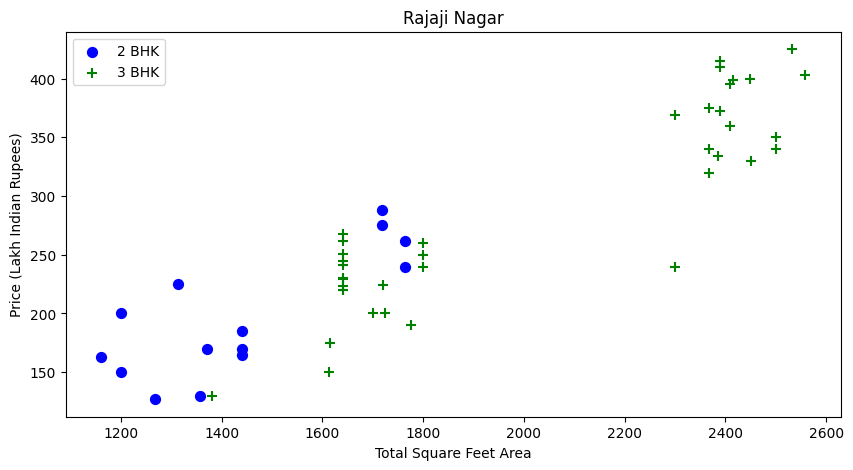

In [35]:
def plot_scatter_chart(df,location):
    bhk2 = df[(df.location==location) & (df.bhk==2)]
    bhk3 = df[(df.location==location) & (df.bhk==3)]
    matplotlib.rcParams['figure.figsize'] = (10,5)
    plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,marker='+', color='green',label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (Lakh Indian Rupees)")
    plt.title(location)
    plt.legend()
    
plot_scatter_chart(df7,"Rajaji Nagar")

In [38]:
df7.describe()

,total_sqft,bath,price,bhk,price_per_sqft
count,10242.000000,10242.000000,10242.000000,10242.000000,10242.000000
mean,1504.023111,2.474419,90.991421,2.572642,5657.735993
std,876.798065,0.981908,86.147833,0.897242,2266.368844
min,300.000000,1.000000,10.000000,1.000000,1250.000000
25%,1108.000000,2.000000,49.000000,2.000000,4244.796706
50%,1282.000000,2.000000,67.000000,2.000000,5172.846776
75%,1650.000000,3.000000,100.000000,3.000000,6426.000592
max,30400.000000,16.000000,2200.000000,16.000000,24509.803922


In [44]:
x = df7[['price_per_sqft', 'bhk']] # Features
y = df7['price']

splitting data into 80-20 for training and testing

In [45]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

using linear regression to train model

In [47]:
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

making predictions


In [48]:
y_pred = model.predict(x_test)

Evaluate model performance

In [49]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [50]:
print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")

Mean Squared Error: 1671.22
R² Score: 0.70


testing with random value

In [51]:
new_house = np.array([[1500, 3]])
predicted_price = model.predict(new_house)
print(f"Predicted Price for 1500 sq ft, 3-bedroom house: ${predicted_price[0]:,.2f}")

Predicted Price for 1500 sq ft, 3-bedroom house: $9.29


c:\Users\GODFATHER07\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


plotting actual vs predicted prices

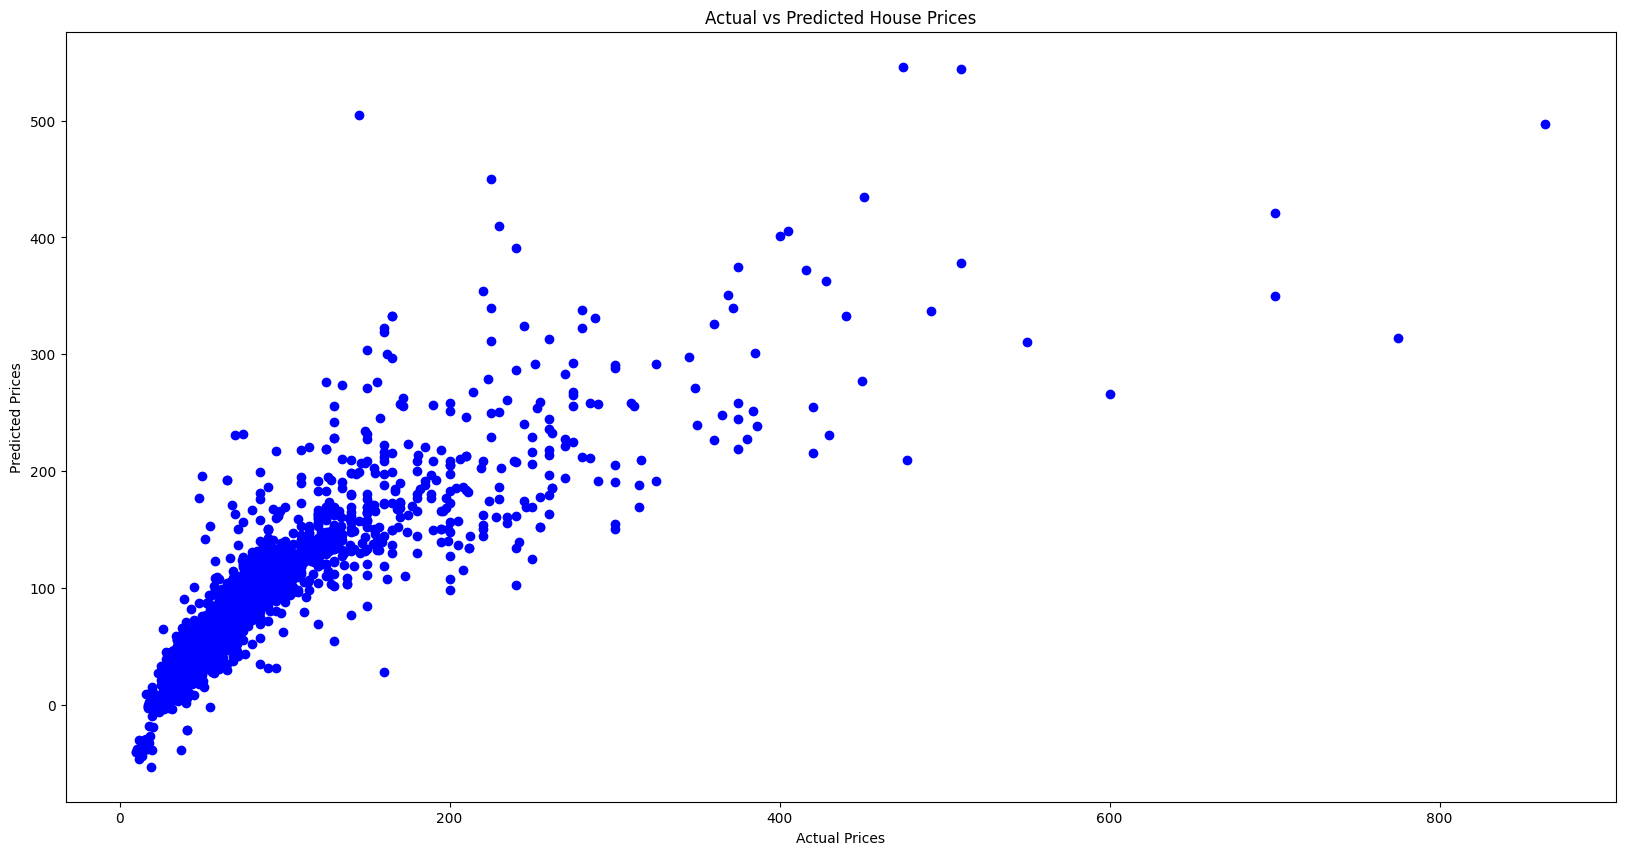

In [52]:
plt.scatter(y_test, y_pred, color='blue')
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted House Prices")
plt.show()